<a href="https://colab.research.google.com/github/christianbammann/introtoML/blob/main/homework7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Problem 1a**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split

from sklearn import metrics

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

full_trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform
)

train_size = int(0.8 * len(full_trainset))
val_size = len(full_trainset) - train_size
trainset, valset = torch.utils.data.random_split(full_trainset, [train_size, val_size])

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform
)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader   = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=False)
testloader  = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

print(f"Train size: {len(trainset)}")
print(f"Val size:   {len(valset)}")
print(f"Test size:  {len(testset)}")
print(f"Classes:    {full_trainset.classes}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

100%|██████████| 170M/170M [00:04<00:00, 37.2MB/s]


Train size: 40000
Val size:   10000
Test size:  10000
Classes:    ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Device: cuda


In [4]:
class SmallCNN(nn.Module):
    def __init__(self):
        super(SmallCNN, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),    # → 16 × 16 × 16

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)     # → 32 × 8 × 8
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(32 * 8 * 8, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

model = SmallCNN().to(device)

total_params = sum(p.numel() for p in model.parameters())
print("Parameters:", total_params)

Parameters: 136874


In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 20

train_losses = []
val_losses = []

start_time = time.time()

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(trainloader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    val_running_loss = 0.0
    with torch.no_grad():
        for images, labels in valloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()

    avg_val_loss = val_running_loss / len(valloader)
    val_losses.append(avg_val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}]  "
          f"Train Loss: {avg_train_loss:.4f}  "
          f"Val Loss: {avg_val_loss:.4f}")

end_time = time.time()

training_time = end_time - start_time
print("\nTraining complete.")
print(f"Total training time: {training_time:.2f} seconds")
print(f"Estimated 300-epoch time: {training_time * (300/20):.2f} seconds")

Epoch [1/20]  Train Loss: 1.5566  Val Loss: 1.3188
Epoch [2/20]  Train Loss: 1.2179  Val Loss: 1.1540
Epoch [3/20]  Train Loss: 1.0638  Val Loss: 1.0779
Epoch [4/20]  Train Loss: 0.9636  Val Loss: 1.0067
Epoch [5/20]  Train Loss: 0.8913  Val Loss: 1.0107
Epoch [6/20]  Train Loss: 0.8380  Val Loss: 0.9630
Epoch [7/20]  Train Loss: 0.7904  Val Loss: 0.9495
Epoch [8/20]  Train Loss: 0.7479  Val Loss: 0.9990
Epoch [9/20]  Train Loss: 0.7090  Val Loss: 0.9342
Epoch [10/20]  Train Loss: 0.6709  Val Loss: 0.9702
Epoch [11/20]  Train Loss: 0.6415  Val Loss: 0.9325
Epoch [12/20]  Train Loss: 0.6086  Val Loss: 0.9693
Epoch [13/20]  Train Loss: 0.5785  Val Loss: 0.9917
Epoch [14/20]  Train Loss: 0.5486  Val Loss: 1.0368
Epoch [15/20]  Train Loss: 0.5255  Val Loss: 1.0846
Epoch [16/20]  Train Loss: 0.4970  Val Loss: 1.0842
Epoch [17/20]  Train Loss: 0.4720  Val Loss: 1.1018
Epoch [18/20]  Train Loss: 0.4517  Val Loss: 1.1060
Epoch [19/20]  Train Loss: 0.4233  Val Loss: 1.1730
Epoch [20/20]  Train 

In [8]:
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Metrics
acc = metrics.accuracy_score(all_labels, all_preds)
pre = metrics.precision_score(all_labels, all_preds, average='macro')
rec = metrics.recall_score(all_labels, all_preds, average='macro')
f1 = metrics.f1_score(all_labels, all_preds, average='macro')

print(f"Accuracy:  {acc:.3f}")
print(f"Precision:      {pre:.3f}")
print(f"Recall:         {rec:.3f}")
print(f"F1 Score:       {f1:.3f}")

Accuracy:  0.676
Precision:      0.677
Recall:         0.676
F1 Score:       0.675


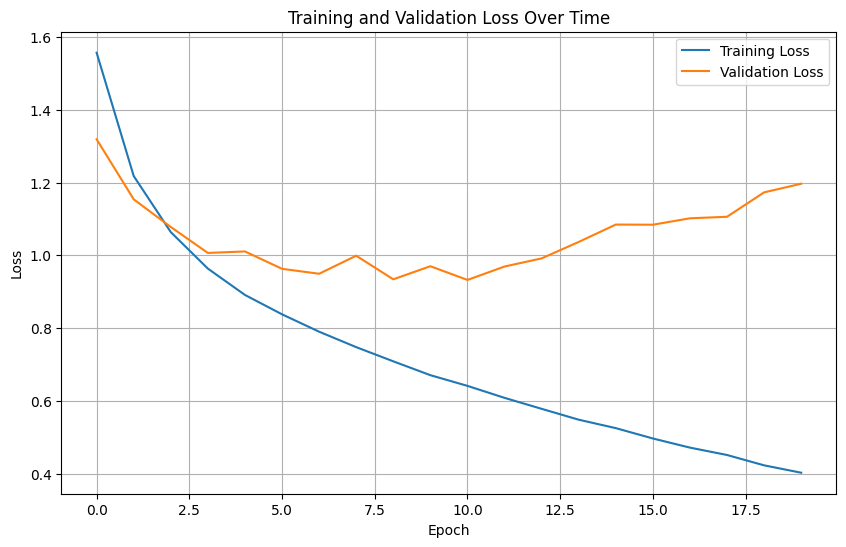

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Time')
plt.legend()
plt.grid(True)
plt.show()

### **Problem 1b**

In [10]:
class BiggerCNN(nn.Module):
    def __init__(self):
        super(BiggerCNN, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),    # -> 16×16×16

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),    # -> 32×8×8

            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # NEW
            nn.ReLU(),
            nn.MaxPool2d(2, 2)     # -> 64×4×4
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(64 * 4 * 4, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

model = BiggerCNN().to(device)

total_params = sum(p.numel() for p in model.parameters())
print("Total parameters:", total_params)

Total parameters: 156074


In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 30

train_losses = []
val_losses = []

start_time = time.time()

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(trainloader)
    train_losses.append(avg_train_loss)

    model.eval()
    val_running_loss = 0.0
    with torch.no_grad():
        for images, labels in valloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()

    avg_val_loss = val_running_loss / len(valloader)
    val_losses.append(avg_val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}]  "
          f"Train Loss: {avg_train_loss:.4f}  "
          f"Val Loss: {avg_val_loss:.4f}")

end_time = time.time()

training_time = end_time - start_time
print("\nTraining complete.")
print(f"Total training time: {training_time:.2f} seconds")
print(f"Estimated 300-epoch time: {training_time * (300/20):.2f} seconds")

Epoch [1/30]  Train Loss: 1.4433  Val Loss: 1.2618
Epoch [2/30]  Train Loss: 1.1617  Val Loss: 1.1161
Epoch [3/30]  Train Loss: 0.9885  Val Loss: 0.9912
Epoch [4/30]  Train Loss: 0.8755  Val Loss: 0.9357
Epoch [5/30]  Train Loss: 0.7965  Val Loss: 0.8699
Epoch [6/30]  Train Loss: 0.7280  Val Loss: 0.8629
Epoch [7/30]  Train Loss: 0.6688  Val Loss: 0.8596
Epoch [8/30]  Train Loss: 0.6079  Val Loss: 0.8529
Epoch [9/30]  Train Loss: 0.5592  Val Loss: 0.8231
Epoch [10/30]  Train Loss: 0.5112  Val Loss: 0.8807
Epoch [11/30]  Train Loss: 0.4639  Val Loss: 0.9157
Epoch [12/30]  Train Loss: 0.4238  Val Loss: 0.9911
Epoch [13/30]  Train Loss: 0.3843  Val Loss: 0.9648
Epoch [14/30]  Train Loss: 0.3436  Val Loss: 0.9604
Epoch [15/30]  Train Loss: 0.3084  Val Loss: 1.0574
Epoch [16/30]  Train Loss: 0.2724  Val Loss: 1.1417
Epoch [17/30]  Train Loss: 0.2432  Val Loss: 1.2318
Epoch [18/30]  Train Loss: 0.2138  Val Loss: 1.2935
Epoch [19/30]  Train Loss: 0.1975  Val Loss: 1.3510
Epoch [20/30]  Train 

In [13]:
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

acc = metrics.accuracy_score(all_labels, all_preds)
pre = metrics.precision_score(all_labels, all_preds, average='macro')
rec = metrics.recall_score(all_labels, all_preds, average='macro')
f1 = metrics.f1_score(all_labels, all_preds, average='macro')

print(f"Test Accuracy:  {acc:.3f}")
print(f"Precision:      {pre:.3f}")
print(f"Recall:         {rec:.3f}")
print(f"F1 Score:       {f1:.3f}")

Test Accuracy:  0.694
Precision:      0.696
Recall:         0.694
F1 Score:       0.694


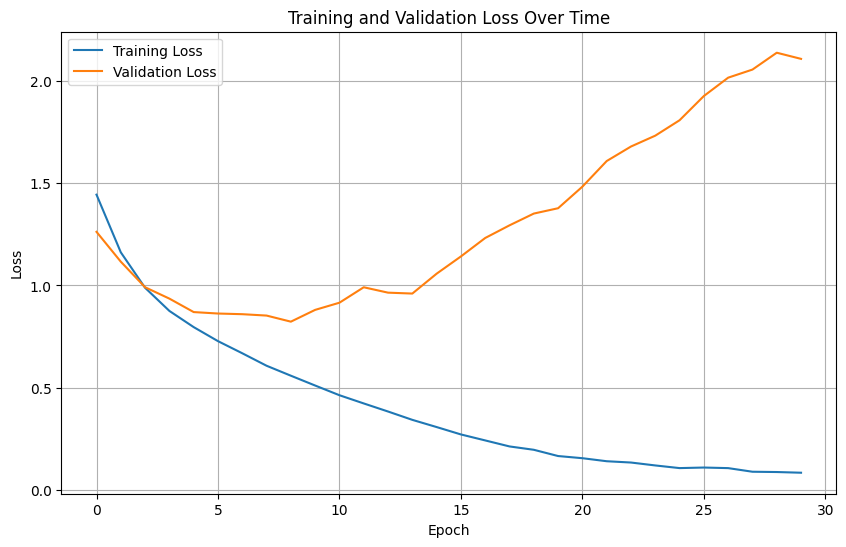

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Time')
plt.legend()
plt.grid(True)
plt.show()

### **Problem 2a**

In [15]:
import torch.nn as nn
import torch.nn.functional as F

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels,
                               kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels,
                               kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [16]:
class ResNet10(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet10, self).__init__()

        self.in_channels = 16

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)

        self.layer1 = self._make_layer(16, 2, stride=1)   # 2 blocks
        self.layer2 = self._make_layer(32, 2, stride=2)   # 2 blocks
        self.layer3 = self._make_layer(64, 2, stride=2)   # 2 blocks
        self.layer4 = self._make_layer(128, 2, stride=2)  # 2 blocks

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(128, num_classes)

    def _make_layer(self, out_channels, blocks, stride):
        layers = []
        layers.append(BasicBlock(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(BasicBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


model = ResNet10().to(device)
total_params = sum(p.numel() for p in model.parameters())
print("Total parameters:", total_params)

Total parameters: 701466


In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 30

train_losses = []
val_losses = []

start_time = time.time()

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(trainloader)
    train_losses.append(avg_train_loss)

    model.eval()
    val_running_loss = 0.0
    with torch.no_grad():
        for images, labels in valloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()

    avg_val_loss = val_running_loss / len(valloader)
    val_losses.append(avg_val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}]  "
          f"Train Loss: {avg_train_loss:.4f}  "
          f"Val Loss: {avg_val_loss:.4f}")

end_time = time.time()
training_time = end_time - start_time

print("\nTraining complete.")
print(f"Total training time: {training_time:.2f} seconds")
print(f"Estimated 300-epoch time: {training_time * (300/20):.2f} seconds")

Epoch [1/30]  Train Loss: 1.3529  Val Loss: 1.0624
Epoch [2/30]  Train Loss: 0.8913  Val Loss: 0.8301
Epoch [3/30]  Train Loss: 0.7026  Val Loss: 0.7145
Epoch [4/30]  Train Loss: 0.5794  Val Loss: 0.7417
Epoch [5/30]  Train Loss: 0.4790  Val Loss: 0.7516
Epoch [6/30]  Train Loss: 0.3945  Val Loss: 0.6953
Epoch [7/30]  Train Loss: 0.3220  Val Loss: 0.6894
Epoch [8/30]  Train Loss: 0.2492  Val Loss: 0.7466
Epoch [9/30]  Train Loss: 0.1980  Val Loss: 0.8256
Epoch [10/30]  Train Loss: 0.1536  Val Loss: 0.8061
Epoch [11/30]  Train Loss: 0.1293  Val Loss: 0.9134
Epoch [12/30]  Train Loss: 0.1173  Val Loss: 0.9668
Epoch [13/30]  Train Loss: 0.0945  Val Loss: 0.9644
Epoch [14/30]  Train Loss: 0.0859  Val Loss: 0.9844
Epoch [15/30]  Train Loss: 0.0763  Val Loss: 0.9812
Epoch [16/30]  Train Loss: 0.0778  Val Loss: 0.9771
Epoch [17/30]  Train Loss: 0.0719  Val Loss: 0.9729
Epoch [18/30]  Train Loss: 0.0631  Val Loss: 1.0550
Epoch [19/30]  Train Loss: 0.0590  Val Loss: 1.0171
Epoch [20/30]  Train 

In [18]:
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

acc = metrics.accuracy_score(all_labels, all_preds)
pre = metrics.precision_score(all_labels, all_preds, average='macro')
rec = metrics.recall_score(all_labels, all_preds, average='macro')
f1 = metrics.f1_score(all_labels, all_preds, average='macro')

print(f"Test Accuracy:  {acc:.3f}")
print(f"Precision:      {pre:.3f}")
print(f"Recall:         {rec:.3f}")
print(f"F1 Score:       {f1:.3f}")

Test Accuracy:  0.779
Precision:      0.780
Recall:         0.779
F1 Score:       0.778


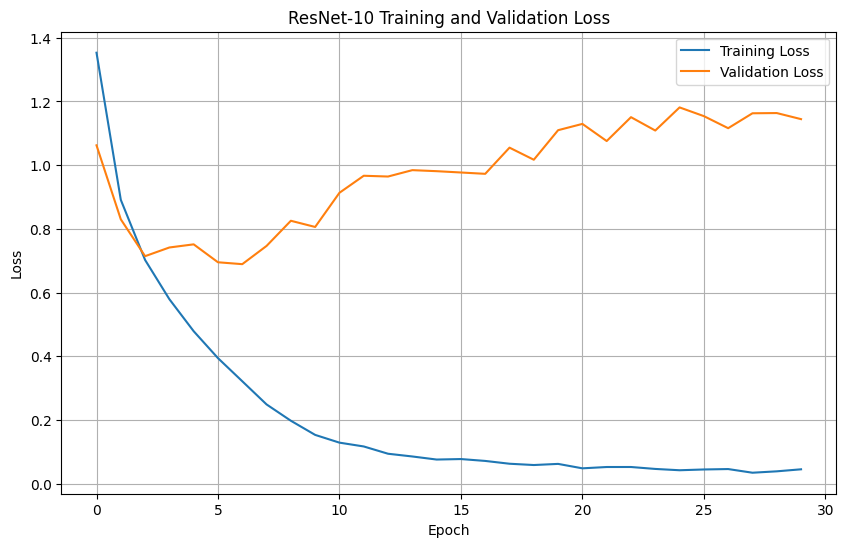

In [19]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('ResNet-10 Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

### **Problem 2b**

In [20]:
model = ResNet10().to(device)
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)

num_epochs = 20

train_losses = []
val_losses = []

start_time = time.time()

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(trainloader)
    train_losses.append(avg_train_loss)

    model.eval()
    val_running_loss = 0.0
    with torch.no_grad():
        for images, labels in valloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()

    avg_val_loss = val_running_loss / len(valloader)
    val_losses.append(avg_val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}]  "
          f"Train Loss: {avg_train_loss:.4f}  "
          f"Val Loss: {avg_val_loss:.4f}")

end_time = time.time()

training_time = end_time - start_time
print("\n[WEIGHT DECAY] Training complete.")
print(f"Total training time: {training_time:.2f} seconds")
print(f"Estimated 300-epoch time: {training_time * (300/20):.2f} seconds")

Epoch [1/20]  Train Loss: 1.3636  Val Loss: 1.1467
Epoch [2/20]  Train Loss: 0.9567  Val Loss: 0.9322
Epoch [3/20]  Train Loss: 0.7866  Val Loss: 0.8747
Epoch [4/20]  Train Loss: 0.6829  Val Loss: 0.7442
Epoch [5/20]  Train Loss: 0.6117  Val Loss: 0.7440
Epoch [6/20]  Train Loss: 0.5466  Val Loss: 0.6611
Epoch [7/20]  Train Loss: 0.5031  Val Loss: 0.7176
Epoch [8/20]  Train Loss: 0.4604  Val Loss: 0.6563
Epoch [9/20]  Train Loss: 0.4308  Val Loss: 0.6528
Epoch [10/20]  Train Loss: 0.3961  Val Loss: 0.6792
Epoch [11/20]  Train Loss: 0.3730  Val Loss: 0.6486
Epoch [12/20]  Train Loss: 0.3460  Val Loss: 0.6368
Epoch [13/20]  Train Loss: 0.3260  Val Loss: 0.7413
Epoch [14/20]  Train Loss: 0.3067  Val Loss: 0.6736
Epoch [15/20]  Train Loss: 0.2910  Val Loss: 0.7417
Epoch [16/20]  Train Loss: 0.2741  Val Loss: 0.7110
Epoch [17/20]  Train Loss: 0.2752  Val Loss: 0.6757
Epoch [18/20]  Train Loss: 0.2564  Val Loss: 0.7129
Epoch [19/20]  Train Loss: 0.2445  Val Loss: 0.6604
Epoch [20/20]  Train 

In [21]:
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

acc = metrics.accuracy_score(all_labels, all_preds)
print("Weight Decay Test Accuracy:", acc)

Weight Decay Test Accuracy: 0.7883


In [22]:
class ResNet10_Dropout(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet10_Dropout, self).__init__()

        self.in_channels = 16

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)

        self.layer1 = ResNet10().layer1
        self.layer2 = ResNet10().layer2
        self.layer3 = ResNet10().layer3
        self.layer4 = ResNet10().layer4

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        self.dropout = nn.Dropout(p=0.3)

        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)

        x = self.dropout(x)  # ---- NEW ----

        x = self.fc(x)
        return x

In [23]:
model = ResNet10_Dropout().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 20

train_losses = []
val_losses = []

start_time = time.time()

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(trainloader)
    train_losses.append(avg_train_loss)

    model.eval()
    val_running_loss = 0.0
    with torch.no_grad():
        for images, labels in valloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()

    avg_val_loss = val_running_loss / len(valloader)
    val_losses.append(avg_val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}]  "
          f"Train Loss: {avg_train_loss:.4f}  "
          f"Val Loss: {avg_val_loss:.4f}")

end_time = time.time()
training_time = end_time - start_time

print("\n[DROPOUT] Training complete.")
print(f"Total training time: {training_time:.2f} seconds")
print(f"Estimated 300-epoch time: {training_time * (300/20):.2f} seconds")

Epoch [1/20]  Train Loss: 1.3977  Val Loss: 1.2715
Epoch [2/20]  Train Loss: 0.9558  Val Loss: 0.8873
Epoch [3/20]  Train Loss: 0.7585  Val Loss: 0.8078
Epoch [4/20]  Train Loss: 0.6328  Val Loss: 0.6999
Epoch [5/20]  Train Loss: 0.5409  Val Loss: 0.6727
Epoch [6/20]  Train Loss: 0.4640  Val Loss: 0.6632
Epoch [7/20]  Train Loss: 0.3837  Val Loss: 0.7330
Epoch [8/20]  Train Loss: 0.3257  Val Loss: 0.6587
Epoch [9/20]  Train Loss: 0.2633  Val Loss: 0.7370
Epoch [10/20]  Train Loss: 0.2125  Val Loss: 0.7228
Epoch [11/20]  Train Loss: 0.1779  Val Loss: 0.8246
Epoch [12/20]  Train Loss: 0.1538  Val Loss: 0.7974
Epoch [13/20]  Train Loss: 0.1287  Val Loss: 0.8410
Epoch [14/20]  Train Loss: 0.1120  Val Loss: 0.9341
Epoch [15/20]  Train Loss: 0.1128  Val Loss: 0.9679
Epoch [16/20]  Train Loss: 0.0942  Val Loss: 0.9880
Epoch [17/20]  Train Loss: 0.0854  Val Loss: 0.9849
Epoch [18/20]  Train Loss: 0.0739  Val Loss: 1.0369
Epoch [19/20]  Train Loss: 0.0771  Val Loss: 0.9496
Epoch [20/20]  Train 

In [24]:
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

acc = metrics.accuracy_score(all_labels, all_preds)
precision = metrics.precision_score(all_labels, all_preds, average='macro')
recall = metrics.recall_score(all_labels, all_preds, average='macro')
f1 = metrics.f1_score(all_labels, all_preds, average='macro')

print("Dropout Test Accuracy:", acc)
print("Precision:", precision)
print("Recall:", recall)
print("F1:", f1)

Dropout Test Accuracy: 0.7683
Precision: 0.7864354143827212
Recall: 0.7683
F1: 0.7697887671803662
